# Data Augmentation - Baseline (no augmentation)

This noteboook simply fits the model without augmentation to provide a baseline to compare to


Import libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import layers


Download our dataset (~8GB):

In [2]:
df, metadata = tfds.load(
    'patch_camelyon',
    data_dir= 'D:\\tensorflow_datasets\\patch_camelyon' ,
    with_info=True,
    as_supervised=True,
)

train_data = df['train']
valid_data = df['validation']
test_data = df['test']

train_data

<PrefetchDataset shapes: ((96, 96, 3), ()), types: (tf.uint8, tf.int64)>

There are two classes:
0 represents no metastatic tissue and 1 indicates that the image does contain metastatic tissue

In [3]:
num_classes=metadata.features['label'].num_classes
class_names = metadata.features['label'].names
print(class_names)

['0', '1']


Let's display an example image from the dataset to see what we are working with:

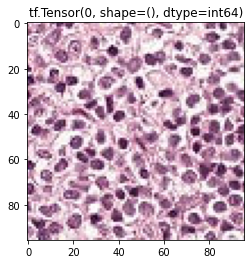

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_data))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))


All images in this dataset are 96x96 RGB, so we don't have to do any resizing or reshaping. However, we will want to rescale our images from 0-255 to 0-1 and convert to float32 for augmentation functions

In [5]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 255.0)
    return image, label

#Applying the preprocess function we the use of map() method
train_data = train_data.map(preprocess)
valid_data = valid_data.map(preprocess)
test_data = test_data.map(preprocess)

#Shuffling the train_data
buffer_size = 1000
train_data = train_data.shuffle(buffer_size)

#Batching and prefetching
#would set batch higher, but this is the most my GPU can handle
batch_size = 12
train_data = train_data.batch(batch_size).prefetch(1)
valid_data = valid_data.batch(batch_size).prefetch(1)
test_data = test_data.batch(batch_size).prefetch(1)

In [6]:
#Seperating image and label into different variables
train_images, train_labels = next(iter(train_data))
valid_images, valid_labels = next(iter(valid_data))
test_images, test_labels  = next(iter(test_data))

#Checking the label shape
valid_labels.shape

#Checking the image shape
train_images.shape


TensorShape([12, 96, 96, 3])

And then we set up our model. I used the model from https://medium.com/analytics-vidhya/deep-learning-tutorial-patch-camelyon-data-set-d0da9034550e to as a baseline. 

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = tf.keras.Sequential([
                    Conv2D(256, 3,padding='same', kernel_initializer='he_uniform', activation='relu', input_shape = [96, 96, 3]),
                    MaxPooling2D(2),
                    Conv2D(256, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(512, 3,padding='same',kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(512, 3,padding='same',kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(1024, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(1024, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(1028,kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(512,kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(1, activation = 'sigmoid'),
                    ])



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       2

Compile model:

In [8]:
# set learning rate to 0.0001, use binary cross entropy loss since our labels are binary
from tensorflow.keras import optimizers

learning_rate = 1e-4
model.compile(optimizer=optimizers.Adam(learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Train model:

In [9]:
epochs=30
history = model.fit(
  train_images,
  train_labels,
  validation_data=valid_data,
  epochs=epochs,
  verbose=2
)


Epoch 1/30
1/1 - 61s - loss: 3.0859 - accuracy: 0.3333 - val_loss: 2.3539 - val_accuracy: 0.4995
Epoch 2/30
1/1 - 56s - loss: 1.6633 - accuracy: 0.6667 - val_loss: 0.9318 - val_accuracy: 0.5005
Epoch 3/30
1/1 - 56s - loss: 1.1126 - accuracy: 0.3333 - val_loss: 1.6599 - val_accuracy: 0.4995
Epoch 4/30
1/1 - 56s - loss: 1.1424 - accuracy: 0.6667 - val_loss: 1.1096 - val_accuracy: 0.4995
Epoch 5/30
1/1 - 56s - loss: 0.7592 - accuracy: 0.6667 - val_loss: 0.7546 - val_accuracy: 0.5003
Epoch 6/30
1/1 - 56s - loss: 0.8401 - accuracy: 0.3333 - val_loss: 0.6765 - val_accuracy: 0.6630
Epoch 7/30
1/1 - 56s - loss: 0.5994 - accuracy: 0.9167 - val_loss: 1.0258 - val_accuracy: 0.4995
Epoch 8/30
1/1 - 56s - loss: 0.6921 - accuracy: 0.6667 - val_loss: 0.9662 - val_accuracy: 0.4995
Epoch 9/30
1/1 - 56s - loss: 0.6384 - accuracy: 0.6667 - val_loss: 0.6780 - val_accuracy: 0.6671
Epoch 10/30
1/1 - 56s - loss: 0.5458 - accuracy: 0.9167 - val_loss: 0.6681 - val_accuracy: 0.5255
Epoch 11/30
1/1 - 56s - loss:

In [10]:
loss, acc = model.evaluate(test_data)
print("Accuracy", acc)


2731/2731 [==============================] - 59s 22ms/step - loss: 1.4133 - accuracy: 0.62520s - l
Accuracy 0.625152587890625


Since our training accuracy approaches 1, it looks like we are overfitting to our training data. Since we can't increase the batch size due to memory issues, then we can try a lower learning rate instead